In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    download=True,
    train=True,
    transform=transform
)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

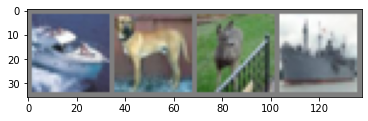

 ship  dog deer ship


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图片
def imgshow(img):
    img = img / 2 + .5 # 逆归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


# 随机获取一些训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

imgshow(torchvision.utils.make_grid(images))
print(''.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
# 定义CNN

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5, 5))
        self.conv2 = nn.Conv2d(6, 16, (5, 5))
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 类似于 x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [17]:
# 损失函数和优化器
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 动量设置为0.9，默认的常规参数

In [18]:
for epoch in range(2): # 在数据集上迭代
    running_loss = .0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # 清空权重梯度
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 打印统计数据
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.204
[1,  4000] loss: 1.881
[1,  6000] loss: 1.680
[1,  8000] loss: 1.607
[1, 10000] loss: 1.507
[1, 12000] loss: 1.471
[2,  2000] loss: 1.419
[2,  4000] loss: 1.377
[2,  6000] loss: 1.349
[2,  8000] loss: 1.343
[2, 10000] loss: 1.310
[2, 12000] loss: 1.315
Finished Training


In [19]:
# 测试集
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test imagesL {0}%'.format(100 * correct / total))


Accuracy of the network on the 10000 test imagesL 53.53%


In [21]:
class_correct = list(0. for i in range(10)) # 10分类，所以列表长度开10
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 42 %
Accuracy of  bird : 43 %
Accuracy of   cat : 31 %
Accuracy of  deer : 48 %
Accuracy of   dog : 33 %
Accuracy of  frog : 63 %
Accuracy of horse : 58 %
Accuracy of  ship : 74 %
Accuracy of truck : 74 %


In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0
